/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_5466/99393713.py:15: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  fg_models = pickle.load(f)
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_5466/99393713.py:27: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sleep_data_resampled = sleep_data.set_index('Timestamp').resample('10S').agg({
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_5466/99393713.py:33: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  index=pd.date_range(start=start_time,
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_5466/99393713.py:94: FutureWarning: 

Passing `palet

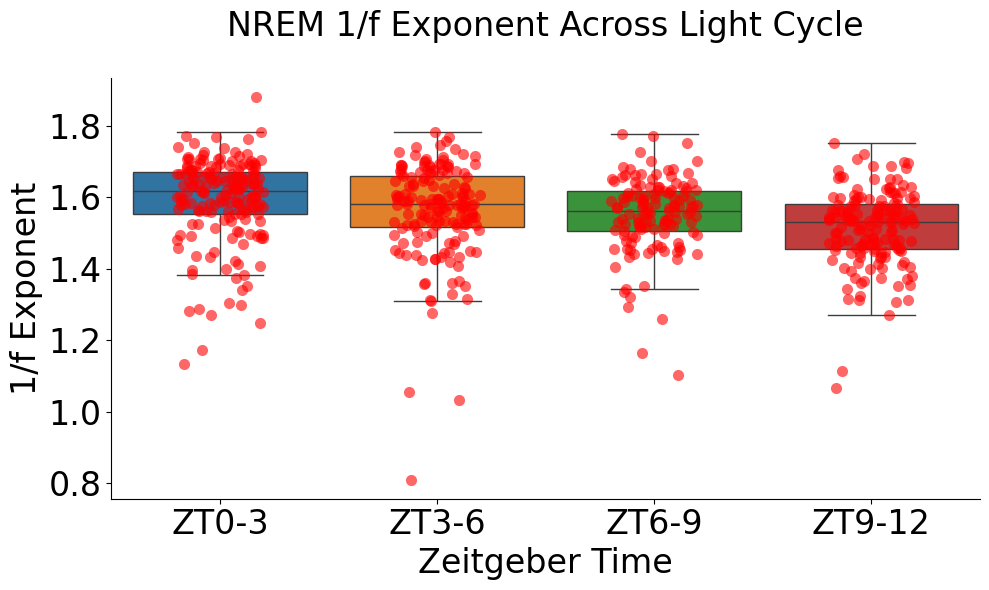

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# File paths
fg_pickle_path = '/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl'
csv_path = '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv'
start_time = '2024-12-16 17:50:46'

# Load FOOOF data
with open(fg_pickle_path, 'rb') as f:
    fg_models = pickle.load(f)

# Calculate average exponents
exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
avg_exps = (exps_eeg1 + exps_eeg2) / 2

# Load and process sleep data
sleep_data = pd.read_csv(csv_path)
sleep_data['Timestamp'] = pd.to_datetime(sleep_data['Timestamp'])

# Resample sleep stages to 10s intervals (mode)
sleep_data_resampled = sleep_data.set_index('Timestamp').resample('10S').agg({
    'sleepStage': lambda x: x.mode()[0]
}).iloc[:-1]  # Remove last row to match exp_series length

# Create exponent series
exp_series = pd.Series(avg_exps, 
                      index=pd.date_range(start=start_time, 
                                        periods=len(avg_exps), 
                                        freq='10S'))

# Combine data
combined_data = pd.DataFrame({
    'timestamp': exp_series.index,
    'hour': exp_series.index.hour,
    'exponent': exp_series.values,
    'sleepStage': sleep_data_resampled['sleepStage']
})

# Filter NREM and convert to ZT time
nrem_data = combined_data[combined_data['sleepStage'] == 2].copy()
nrem_data['zt'] = (nrem_data['hour'] - 9) % 24

# Group into 3-hour blocks
nrem_data['time_block'] = pd.cut(nrem_data['zt'],
                                bins=[-0.1, 3, 6, 9, 12],
                                labels=['ZT0-3', 'ZT3-6', 'ZT6-9', 'ZT9-12'])

# Find NREM bouts and calculate mean exponents
nrem_bouts = []
current_bout = []
current_block = None

# Sort data by timestamp to ensure proper sequence
sorted_data = nrem_data.sort_values('timestamp')

for idx, row in sorted_data.iterrows():
    if not current_bout:
        current_bout = [row]
        current_block = row['time_block']
    else:
        time_diff = (row['timestamp'] - current_bout[-1]['timestamp']).total_seconds()
        
        if time_diff == 10.0:
            current_bout.append(row)
        else:
            if len(current_bout) > 0:
                bout_mean = np.mean([r['exponent'] for r in current_bout])
                nrem_bouts.append((current_block, bout_mean))
            current_bout = [row]
            current_block = row['time_block']

if current_bout:
    bout_mean = np.mean([r['exponent'] for r in current_bout])
    nrem_bouts.append((current_block, bout_mean))

# Create DataFrame for bout means
bout_df = pd.DataFrame(nrem_bouts, columns=['time_block', 'bout_mean'])

# Create figure
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Define consistent order
time_blocks = ['ZT0-3', 'ZT3-6', 'ZT6-9', 'ZT9-12']
colors = plt.cm.tab10(np.linspace(0, 1, 10))[:4]  # Get first 4 colors from tab10

# Create boxplot and stripplot using seaborn
sns.boxplot(data=bout_df, x='time_block', y='bout_mean',
            order=time_blocks,
            palette=colors,
            showfliers=False,
            ax=ax)

sns.stripplot(data=bout_df, x='time_block', y='bout_mean',
             order=time_blocks,
             color='red',
             size=8,
             alpha=0.6,
             jitter=0.2,
             ax=ax)

# Style plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('NREM 1/f Exponent Across Light Cycle - sub-017', fontsize=24, pad=30)
plt.xlabel('Zeitgeber Time', fontsize=24)
plt.ylabel('1/f Exponent', fontsize=24)
plt.tick_params(axis='both', labelsize=24)

plt.tight_layout()
#plt.savefig('/Volumes/harris/volkan/fooof/plots/nrem_exponent/nrem_exponent_light_cycle_boxplot.png', dpi=600)
plt.show()

/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:66: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sleep_data_resampled = sleep_data.set_index('Timestamp').resample('10S').agg({
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:87: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  index=pd.date_range(start=start_time,


Subject 007:
exp_series length: 25560
sleep_data length: 25560


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:66: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sleep_data_resampled = sleep_data.set_index('Timestamp').resample('10S').agg({
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:87: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  index=pd.date_range(start=start_time,


Subject 010:
exp_series length: 25072
sleep_data length: 25072


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:66: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sleep_data_resampled = sleep_data.set_index('Timestamp').resample('10S').agg({
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:87: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  index=pd.date_range(start=start_time,


Subject 011:
exp_series length: 25920
sleep_data length: 25920


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:66: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sleep_data_resampled = sleep_data.set_index('Timestamp').resample('10S').agg({
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:87: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  index=pd.date_range(start=start_time,


Subject 015:
exp_series length: 17646
sleep_data length: 17646


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:66: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sleep_data_resampled = sleep_data.set_index('Timestamp').resample('10S').agg({
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:87: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  index=pd.date_range(start=start_time,


Subject 016:
exp_series length: 32703
sleep_data length: 32703


/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:66: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sleep_data_resampled = sleep_data.set_index('Timestamp').resample('10S').agg({
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:87: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  index=pd.date_range(start=start_time,


Subject 017:
exp_series length: 35310
sleep_data length: 35310
Original data shape: (4815, 3)
Filtered data shape: (2867, 3)

Unique time blocks after filtering: ['ZT3-6' 'ZT6-9' 'ZT9-12' 'ZT0-3']
Linear mixed model fit by REML [’lmerMod’]
Formula: bout_mean~time_block+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 2867	 Groups: {'subject': 6.0}

Log-likelihood: 1923.565 	 AIC: -3835.130

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.015  0.122
Residual               0.015  0.122

No random effect correlations specified

Fixed effects:


ANOVA Results:
SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)
                  SS        MS  NumDF      DenomDF     F-stat         P-val  \
time_block  1.825243  0.608414      3  2858.073643  40.632749  1.043651e-25   

            Sig  
time_block  ***  

Post-hoc Tests:
P-valu

/Users/Volka/miniconda3/envs/fooof_venv/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_10540/2259586942.py:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_bouts, x='time_block', y='bout_mean',


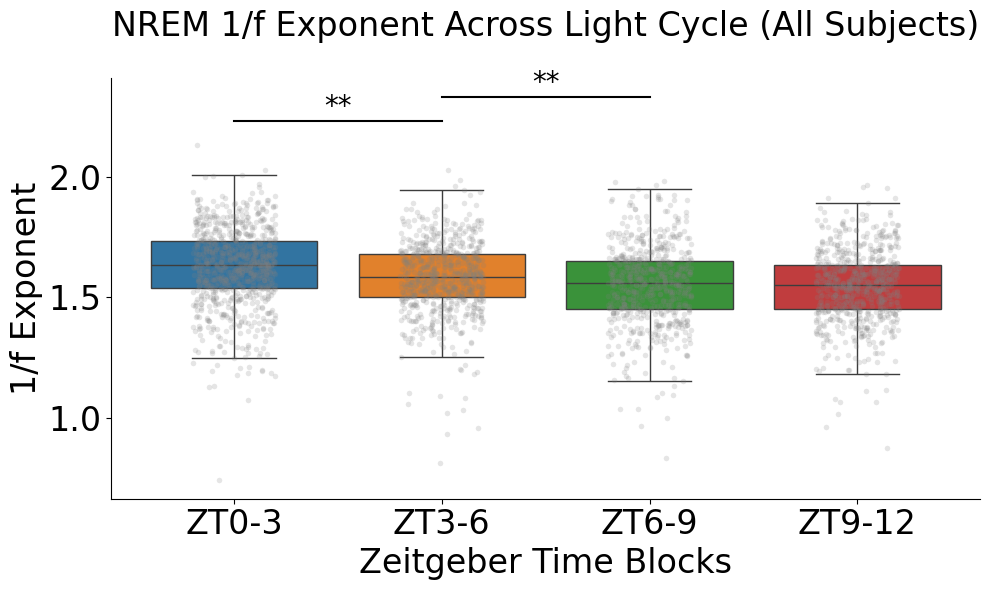

In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
from pymer4.models import Lmer

pickle_files = [
    '/Volumes/harris/volkan/fooof/fooof_results/sub-007_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-010_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-011_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-015_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-016_ses-02_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl'
]

csv_files = [
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_1Hz_stitched.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv'
]

start_times = ['2024-07-02 15:13:12', '2024-09-16 16:01:50','2024-09-25 15:07:30','2024-11-18 12:35:00','2024-11-29 13:29:14','2024-12-16 17:50:47']

# Define exclusion periods for each subject
exclusion_ranges = {
    '015': [('2024-11-19 08:49:50', '2024-11-19 08:57:59')]
}

all_bout_data = []

for fg_pickle_path, csv_path, start_time in zip(pickle_files, csv_files, start_times):
    # Extract subject ID for labeling
    subject_id = fg_pickle_path.split('sub-')[1].split('_')[0]
    
    if not Path(csv_path).exists():
        print(f"Warning: Missing CSV file for {subject_id}")
        continue

    # Load FOOOF data
    with open(fg_pickle_path, 'rb') as f:
        fg_models = pickle.load(f)
    
    # Calculate average exponents
    exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
    exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
    avg_exps = (exps_eeg1 + exps_eeg2) / 2

     # Create resampling function
    def robust_mode(x):
        if len(x) == 0 or x.isna().all():
            return np.nan
        mode_result = x.mode()
        return mode_result[0] if len(mode_result) > 0 else np.nan

    # Load and filter sleep data
    sleep_data = pd.read_csv(csv_path)
    sleep_data['Timestamp'] = pd.to_datetime(sleep_data['Timestamp'])

    # Resample sleep stages to 10s intervals (mode)
    sleep_data_resampled = sleep_data.set_index('Timestamp').resample('10S').agg({
        'sleepStage': robust_mode
    })

    # Apply exclusions after resampling
    if subject_id in exclusion_ranges:
        for start_exc, end_exc in exclusion_ranges[subject_id]:
            mask = ~((sleep_data_resampled.index >= start_exc) & 
                    (sleep_data_resampled.index <= end_exc))
            sleep_data_resampled = sleep_data_resampled[mask]

    # Check if start time is aligned with 10s intervals
    start_seconds = pd.to_datetime(start_time).second
    is_aligned = start_seconds % 10 == 0

    # Only drop last row if not aligned
    if not is_aligned:
        sleep_data_resampled = sleep_data_resampled.iloc[:-1]

    # Create exponent series
    exp_series = pd.Series(avg_exps, 
                      index=pd.date_range(start=start_time, 
                                        periods=len(avg_exps), 
                                        freq='10S'))

    # Verify lengths match
    print(f"Subject {subject_id}:")
    print(f"exp_series length: {len(exp_series)}")
    print(f"sleep_data length: {len(sleep_data_resampled)}")

    # Process NREM bouts
    combined_data = pd.DataFrame({
        'timestamp': exp_series.index,
        'hour': exp_series.index.hour,
        'exponent': exp_series.values,
        'sleepStage': sleep_data_resampled['sleepStage']
    })

    nrem_data = combined_data[combined_data['sleepStage'] == 2].copy()
    nrem_data['zt'] = (nrem_data['hour'] - 9) % 24
    nrem_data['time_block'] = pd.cut(nrem_data['zt'],
                                    bins=[-0.1, 3, 6, 9, 12],
                                    labels=['ZT0-3', 'ZT3-6', 'ZT6-9', 'ZT9-12'])

    # Find NREM bouts
    nrem_bouts = []
    current_bout = []
    current_block = None

    sorted_data = nrem_data.sort_values('timestamp')
    
    for idx, row in sorted_data.iterrows():
        if not current_bout:
            current_bout = [row]
            current_block = row['time_block']
        else:
            time_diff = (row['timestamp'] - current_bout[-1]['timestamp']).total_seconds()
            
            if time_diff == 10.0:
                current_bout.append(row)
            else:
                if len(current_bout) > 0:
                    bout_mean = np.mean([r['exponent'] for r in current_bout])
                    nrem_bouts.append((current_block, bout_mean))
                current_bout = [row]
                current_block = row['time_block']

    if current_bout:
        bout_mean = np.mean([r['exponent'] for r in current_bout])
        nrem_bouts.append((current_block, bout_mean))

    # Create DataFrame for bout means and add subject ID
    bout_df = pd.DataFrame(nrem_bouts, columns=['time_block', 'bout_mean'])
    bout_df['subject'] = subject_id
    all_bout_data.append(bout_df)

# Combine all bout data
combined_bouts = pd.concat(all_bout_data, ignore_index=True)

# Define valid time blocks and filter data
time_blocks = ['ZT0-3', 'ZT3-6', 'ZT6-9', 'ZT9-12']
filtered_bouts = combined_bouts[combined_bouts['time_block'].isin(time_blocks)].copy()

# Verify filtering
print("Original data shape:", combined_bouts.shape)
print("Filtered data shape:", filtered_bouts.shape)
print("\nUnique time blocks after filtering:", filtered_bouts['time_block'].unique())

# Run LMER on filtered data
filtered_bouts['subject'] = filtered_bouts['subject'].astype('category')
filtered_bouts['time_block'] = filtered_bouts['time_block'].astype('category')

model = Lmer("bout_mean ~ time_block + (1|subject)", data=filtered_bouts)
model.fit(
    factors={"time_block": time_blocks},
    ordered=False
)

# Print ANOVA results
print("\nANOVA Results:")
print(model.anova())

# Run post-hoc tests
print("\nPost-hoc Tests:")
marginal_estimates, comparisons = model.post_hoc(
    marginal_vars=["time_block"],
    p_adjust='fdr'
)

print("\nMarginal Estimates:")
print(marginal_estimates)
print("\nPairwise Comparisons:")
print(comparisons)

# Create figure
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Define order and create visualization
time_blocks = ['ZT0-3', 'ZT3-6', 'ZT6-9', 'ZT9-12']

sns.boxplot(data=combined_bouts, x='time_block', y='bout_mean',
            order=time_blocks,
            palette='tab10',
            showfliers=False,
            ax=ax)

sns.stripplot(data=combined_bouts, x='time_block', y='bout_mean',
             order=time_blocks,
             color='grey',
             size=4,
             alpha=0.2,
             jitter=0.2,
             ax=ax)

# Add significance bars for contrasts 1, 4, and 6
contrast_indices = [0, 3, 5]  # Indices for contrasts 1, 4, 6
y_start = filtered_bouts['bout_mean'].max() + 0.1
spacing = 0.1

time_blocks_pvalue = ['(ZT0-3)', '(ZT3-6)', '(ZT6-9)', '(ZT9-12)']

for idx, contrast_idx in enumerate(contrast_indices):
    p_value = comparisons.iloc[contrast_idx]['P-val']
    if p_value < 0.05:
        contrast = comparisons.iloc[contrast_idx]['Contrast']
        groups = contrast.split(' - ')
        
        # Get x-coordinates
        x1 = time_blocks_pvalue.index(groups[0])
        x2 = time_blocks_pvalue.index(groups[1])
        
        # Determine significance stars
        stars = '*'
        if p_value < 0.01:
            stars = '**'
        elif p_value < 0.001:
            stars = '***'
            
        # Plot significance bar
        y = y_start + (idx * spacing)
        plt.plot([x1, x2], [y, y], 'k-', linewidth=1.5)
        plt.text((x1 + x2)/2, y, stars, ha='center', va='bottom', fontsize=20)

# Style plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('NREM 1/f Exponent Across Light Cycle (All Subjects)', fontsize=24, pad=30)
plt.xlabel('Zeitgeber Time Blocks', fontsize=24)
plt.ylabel('1/f Exponent', fontsize=24)
plt.tick_params(axis='both', labelsize=24)

plt.tight_layout()
#plt.savefig('/Volumes/harris/volkan/fooof/plots/nrem_exponent/combined_nrem_exponent_light_cycle.png', dpi=600, bbox_inches='tight')
plt.show()